In [2]:
import matplotlib.ticker as ticker
from pymongo import MongoClient
import pandas as pd
from matplotlib import pyplot as plt

In [19]:
baseline_auc = {
    'name': 'baseline',
    0: {0: 0.5441, 2: 0.7340, 4: 0.6161, 6: 0.7392},
    1: {0: 0.6715, 2: 0.6153, 4: 0.8833, 6: 0.7455},
    2: {0: 0.9619, 2: 0.7897, 4: 0.9430, 6: 0.6959},
    3: {1: 0.8136, 2: 0.8597, 3: 0.6330, 4: 0.8445},
    4: {1: 0.7807, 2: 0.6416, 3: 0.7535},
    5: {0: 0.6876, 2: 0.6818, 4: 0.7430, 6: 0.5390}
    }
    
INVERSE_CLASS_MAP = {
    0: 'fan',
    1: 'pump',
    2: 'slider',
    3: 'ToyCar',
    4: 'ToyConveyor',
    5: 'valve'
}

TRAINING_ID_MAP = {
    0: [0, 2, 4, 6],
    1: [0, 2, 4, 6],
    2: [0, 2, 4, 6],
    3: [1, 2, 3, 4],
    4: [1, 2, 3],
    5: [0, 2, 4, 6]
}

In [20]:
def parallel_coordinates(data_sets, style=None):

    dims = len(data_sets[0])
    x    = range(dims)
    fig, axes = plt.subplots(1, dims-1, sharey=False)

    if style is None:
        style = ['r-']*len(data_sets)

    # Calculate the limits on the data
    min_max_range = list()
    for m in zip(*data_sets):
        mn = min(m)
        mx = max(m)
        if mn == mx:
            mn -= 0.5
            mx = mn + 1.
        r  = float(mx - mn)
        min_max_range.append((mn, mx, r))

    # Normalize the data sets
    norm_data_sets = list()
    for ds in data_sets:
        nds = [(value - min_max_range[dimension][0]) / 
                min_max_range[dimension][2] 
                for dimension,value in enumerate(ds)]
        norm_data_sets.append(nds)
    data_sets = norm_data_sets

    # Plot the datasets on all the subplots
    for i, ax in enumerate(axes):
        for dsi, d in enumerate(data_sets):
            ax.plot(x, d, style[dsi])
        ax.set_xlim([x[i], x[i+1]])

    # Set the x axis ticks 
    for dimension, (axx,xx) in enumerate(zip(axes, x[:-1])):
        axx.xaxis.set_major_locator(ticker.FixedLocator([xx]))
        ticks = len(axx.get_yticklabels())
        labels = list()
        step = min_max_range[dimension][2] / (ticks - 1)
        mn   = min_max_range[dimension][0]
        for i in range(ticks):
            v = mn + i*step
            labels.append('%4.2f' % v)
        axx.set_yticklabels(labels)


    # Move the final axis' ticks to the right-hand side
    axx = plt.twinx(axes[-1])
    dimension += 1
    axx.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    ticks = len(axx.get_yticklabels())
    step = min_max_range[dimension][2] / (ticks - 1)
    mn   = min_max_range[dimension][0]
    labels = ['%4.2f' % (mn + i*step) for i in range(ticks)]
    axx.set_yticklabels(labels)

    # Stack the subplots 
    plt.subplots_adjust(wspace=0)

    return plt

In [21]:
def get_experiment(name='per_mic_normalized', metric='auroc_mean'):
    
    client = MongoClient('mongodb://student2.cp.jku.at:27017/')
    db = client.dcase2020_task2
    db.list_collection_names()

    
    experiment_dict = dict()
    for i in range(6):
        experiment_dict[i] = dict()
    
    experiment_dict['name'] = name
    
    for experiment in db.runs.find(
            {
             "experiment.name": "dcase2020_task2_classification"
            }
    ):
        if experiment['config'].get('descriptor') == name:
            machine_dict = experiment_dict[experiment['config']['machine_type']]
            machine_dict[experiment['config']['machine_id']] = experiment['result'][metric]

    return experiment_dict


def get_record(experiment):
    record = [experiment['name']]
    for i in range(6):
        for j in TRAINING_ID_MAP[i]:
            record.append(experiment[i][j])
    assert len(record) == 24
    return  record
            

In [22]:
data = [
    get_record(baseline_auc),
    get_record(get_experiment('per_mic_norm_same_mic_comp')),
    get_record(get_experiment('per_mic_normalized')),
    # get_record(get_experiment('not_normalized'))
]

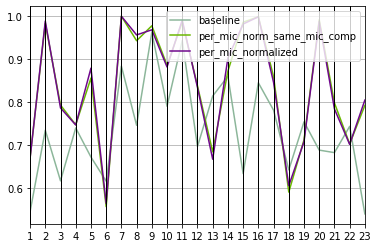

In [23]:
df = pd.DataFrame(data)

pd.plotting.parallel_coordinates(df, 0)
plt.show()